<h1 class="heading"> Maneuver Test</h1>
<h1>Descent from trim and ground effect</h1>

<h6 class="author"> — <b style="color:rgb(0,51,102);">Carmine Varriale, Agostino De Marco</b>, <i>University of Naples Federico II</i></h6>

## Introduction and setup
The purpose of this Notebook is to illustrate how to simulate a descending trajectory in the easiest way, and how ground effect influences a light aircraft motion at very low altitudes above ground level.<br><br>

Here's the modules and functions we are going to need

In [1]:
# Notebook Initialization
% run ./python/nb_init.py                        
% matplotlib inline                              

import plotting_routines as plrt
import data_handling as dh

HTML(open('./style/style_unina_iwes.css', 'r').read())

and here's the list of external files we are going to use throughout the Notebook.

In [2]:
# Directory for output
dest_folder='../output/mantest_descent0_ap/'

# Catalog to file
os.system('../JSBSim/JSBSim --root=../JSBSim/ --catalog=c172x_unina > ../JSBSim/catalog_c172x_unina.txt')

# Reference to script file
script_path='../JSBSim/scripts/c172x_mantest_descent0_ap.xml'

# Reference to initialization file
init_path = '../JSBSim/aircraft/c172x_unina/init_mantest_descent0_ap.xml'

## Script file analysis
The key parameter is input in the initialization file, where we actually state that we are looking for a descending flight path, by assigning a negative value to the angle $\gamma$. You can see from the file below that initial altitude and speed are those typical for an approach maneuver.

In [3]:
dh.show_file(init_path)

   1| <?xml version="1.0"?>                                       
   2| 
   3| <!-- 
   4| Set the aircraft initial condition
   5| at 100 feet above Sea Level, 
   6| over Naples, 
   7| on a heading of 90 degrees,
   8| on a descending flightpath,
   9| with engine running .
  10| -->
  11| 
  12| <initialize name="EngineRunning">
  13|    
  14|   <vt unit="KTS">         46.0  </vt>
  15|   <latitude unit="DEG">   40.0  </latitude>
  16|   <longitude unit="DEG">  14.2  </longitude>
  17|   <psi unit="DEG">        90.0  </psi>
  18|   <altitude unit="FT">   100.0  </altitude>
  19|   <gamma unit="DEG">      -1.0  </gamma>
  20|   <running>                0    </running>                                 
  21|  
  22| </initialize>

In the script, we first set flaps position for landing and make sure wheel brakes are released. Then we trim the aircraft and let it fly completely freely for 10 seconds. Wing leveler autopilot and heading hold are activated shortly after trimming, and not immediately after, in order not to generate discontinuous and diverging responses of the control surfaces. All these considerations can be furtherly elaborated by taking a look at the script below:

In [4]:
dh.show_file(script_path)

   1| <?xml version="1.0"?>
   2| <?xml-stylesheet type="text/xsl" 
   3| 	href="http://jsbsim.sourceforge.net/JSBSimScript.xsl"?>
   4| 
   5| 
   6| <runscript xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
   7| 		xsi:noNamespaceSchemaLocation="http://jsbsim.sf.net/JSBSimScript.xsd"
   8| 		name="Script for C172x - Descent with autopilot">
   9| 
  10| 
  11|     <!--
  12| 		C172x performing a descent with autopilot to
  13|         keep the correct route and wings leveled. The descent
  14|         trajectory is set-up in the initialization script.
  15|         Ground effect on lift can be appreciated.
  16|     -->
  17| 
  18|     <use aircraft="c172x_unina" initialize="init_mantest_descent0_ap" />
  19|     <run start="0.0" end="120" dt="0.0083333"> 
  20| 
  21|         <property value="1">simulation/notify-time-trigger</property>
  22| 
  23| 
  24|         <event name="Flaps">
  25|             <description>Flaps out for landing</description>
  26|             <condi

## Simulation launch
From the time history of altitude $h_\mathrm{SL}$ and elevation angle $\theta$ from $t=60\, \mathrm{s}$ on, it is clear that the proximity of the ground makes lift increase, thus introducing oscillations in an otherwise unperturbed descending trajectory.<br><br>
Just slightly before $t=120\, \mathrm{s}$, a small cusp in the altitude history tells us that the aircraft has finally touched the ground. In particular, from the log file we acknowledge that the first point to touch down was the Left Main Gear.

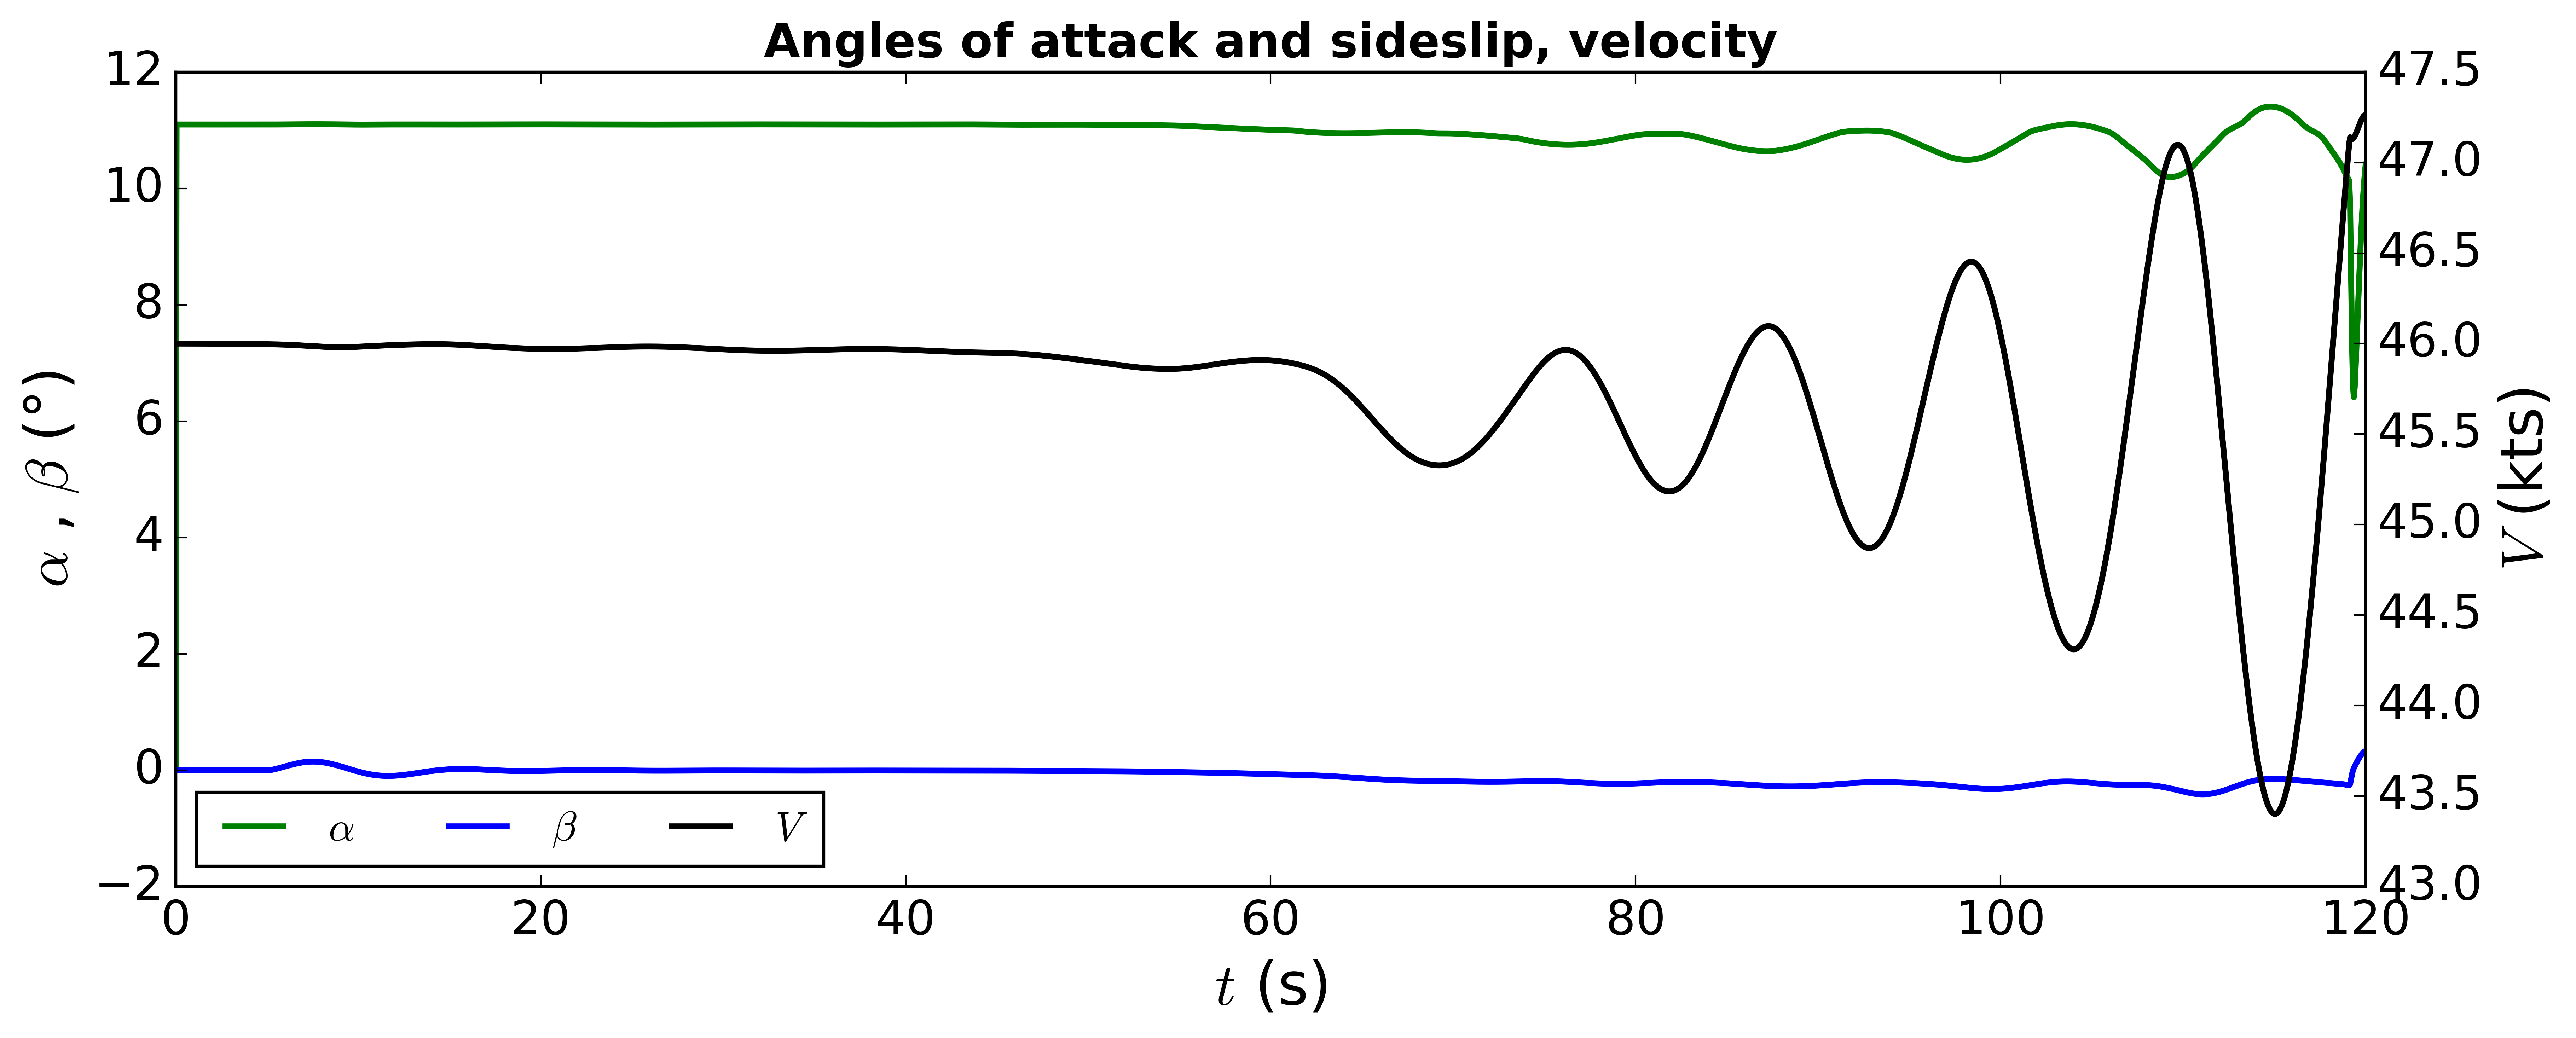

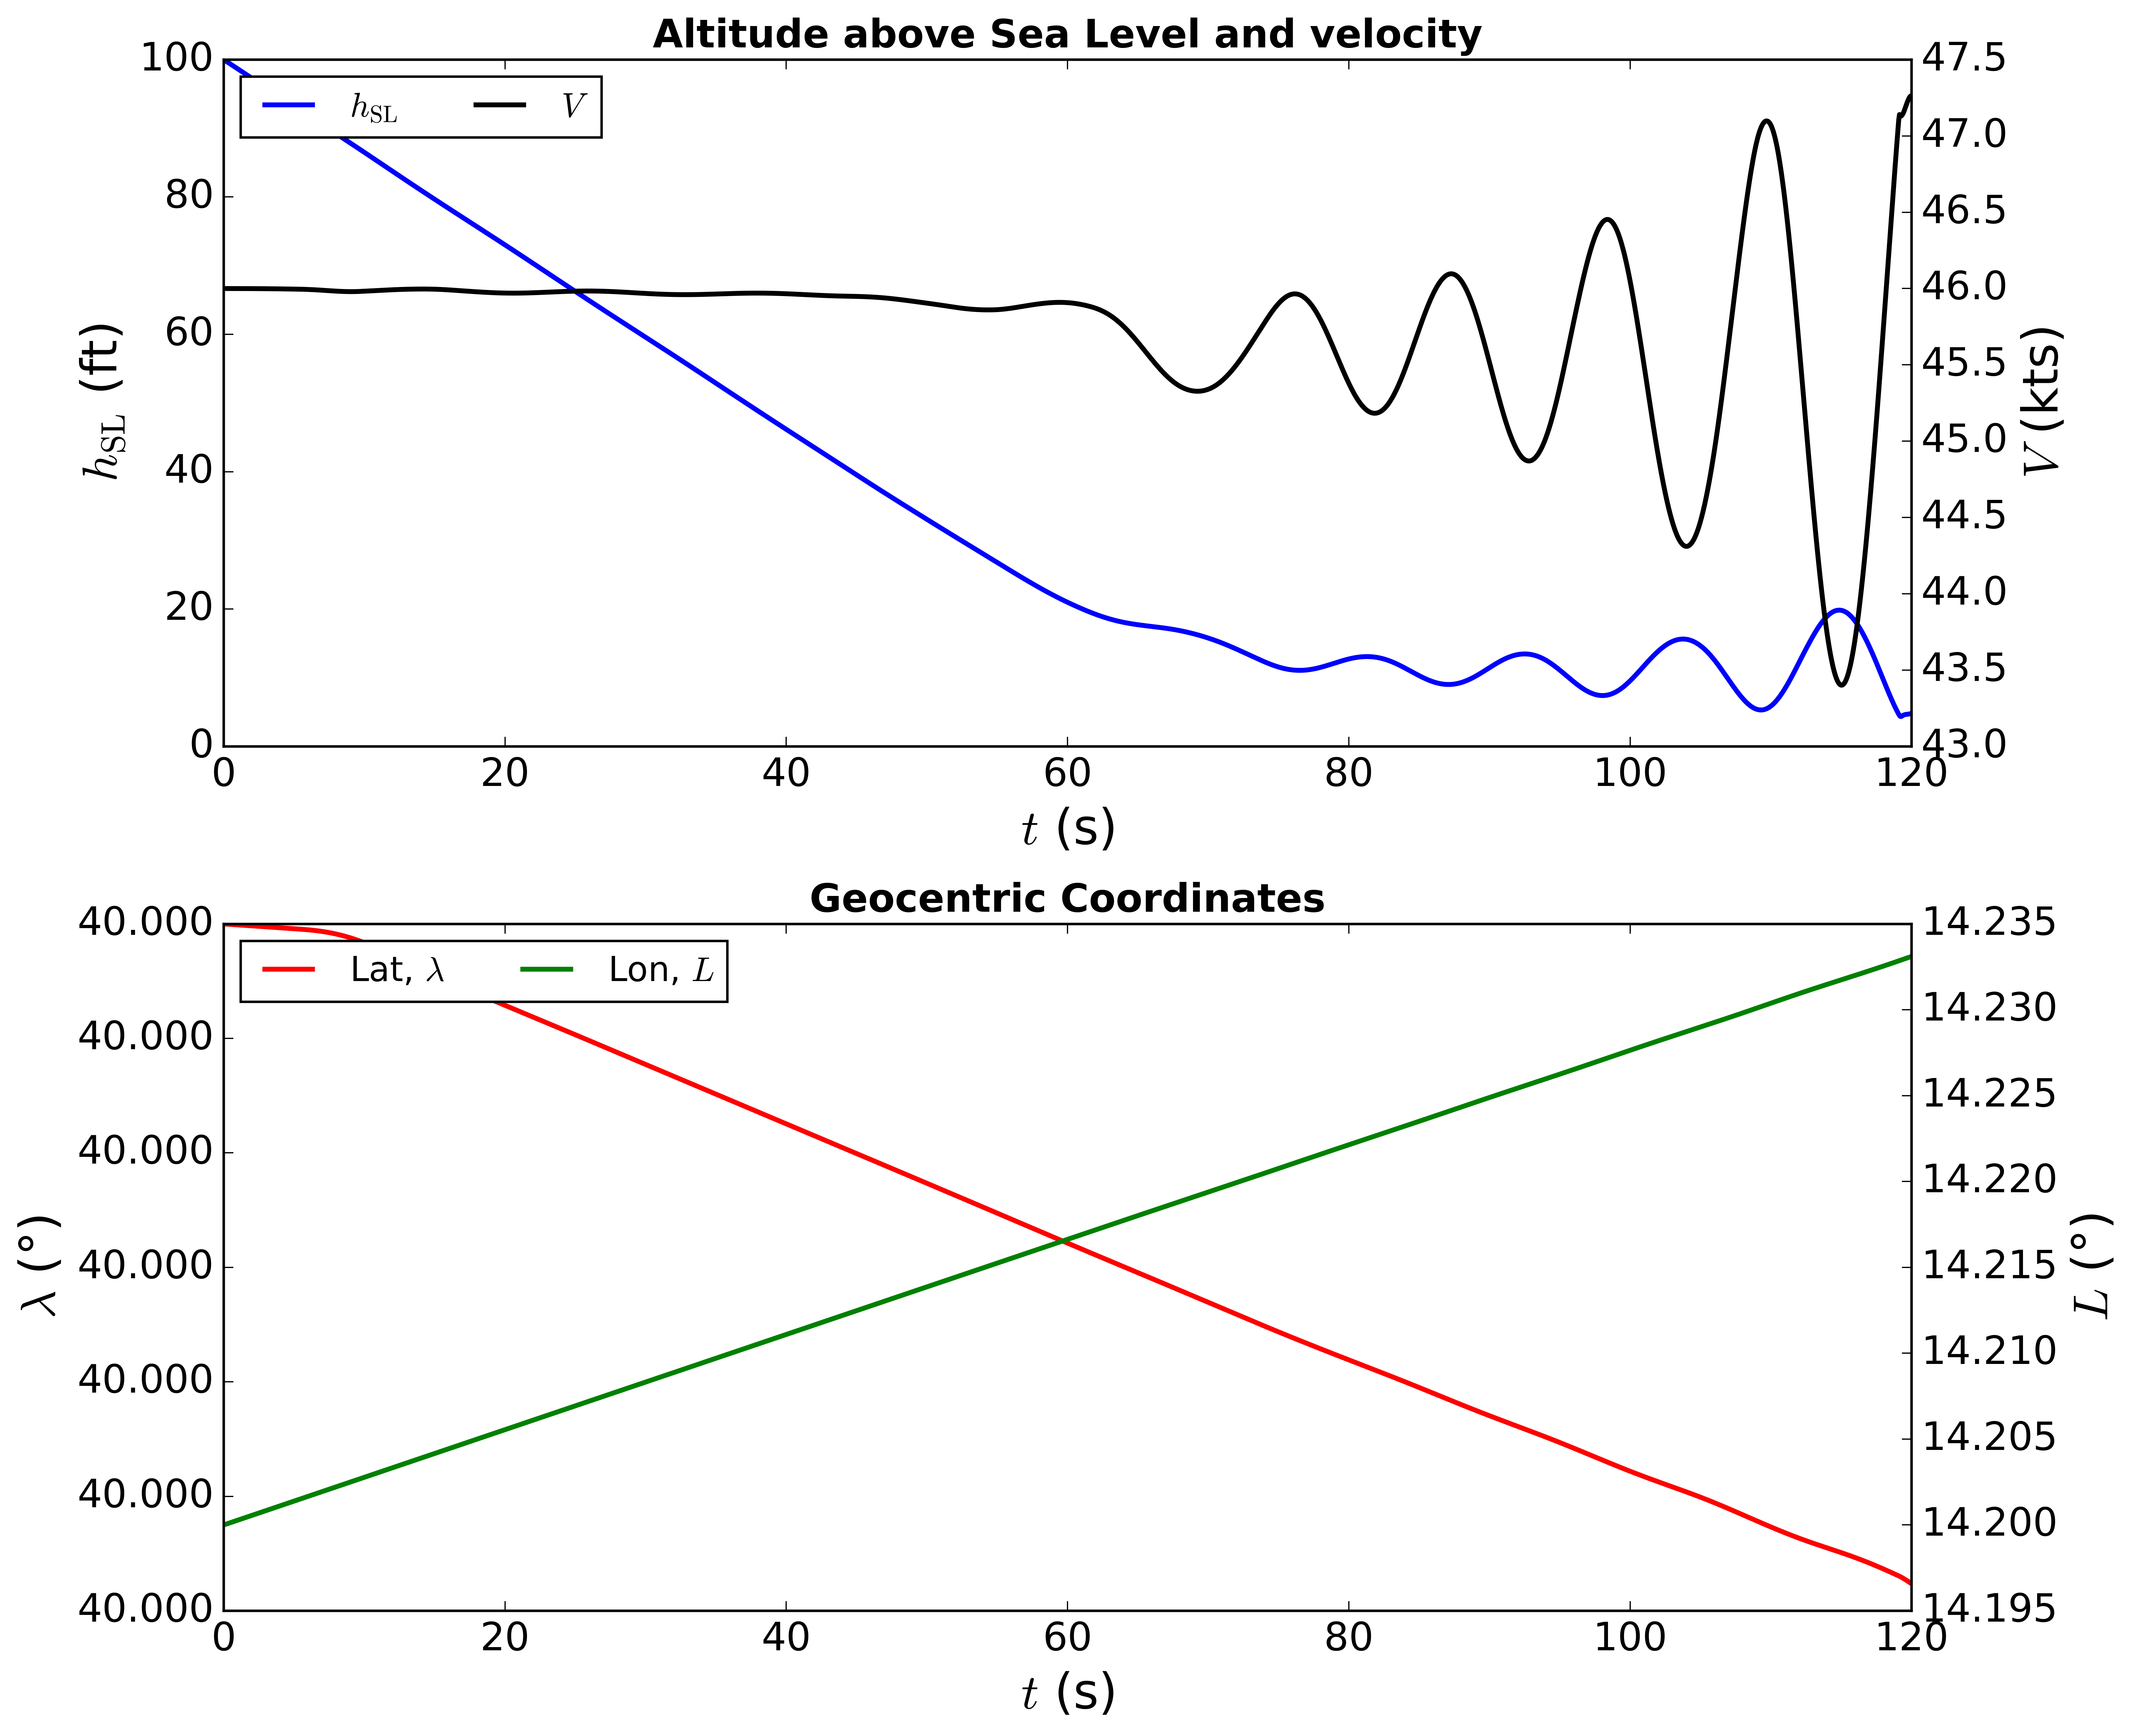

In [5]:
# JSBSim script launch command
os.system('../JSBSim/JSBSim --root=../JSBSim/ --script='+script_path+' > ../JSBSim/log_descent0_ap.txt')

dh.move_files_to_folder('*.csv',dest_folder,'../JSBSim/')
dh.move_files_to_folder('*.txt',dest_folder,'../JSBSim/')

# Data extraction from JSBSim custom output files
data_fcs = np.genfromtxt(dest_folder+'C172x_unina_fcs.csv',       delimiter=',', skip_header=1)
data_vel = np.genfromtxt(dest_folder+'C172x_unina_velocities.csv',delimiter=',', skip_header=1)
data_att = np.genfromtxt(dest_folder+'C172x_unina_attitude.csv',  delimiter=',', skip_header=1)
data_aer = np.genfromtxt(dest_folder+'C172x_unina_aero.csv',      delimiter=',', skip_header=1)
data_pos = np.genfromtxt(dest_folder+'C172x_unina_position.csv',  delimiter=',', skip_header=1)
data_eng = np.genfromtxt(dest_folder+'C172x_unina_propulsion.csv',delimiter=',', skip_header=1)

# Time histories
plrt.plot_Cmd_AngVel_EulerAng(data_fcs, data_vel, data_att, dest_folder)
plrt.plot_Alfa_Beta_V(data_aer, data_vel, dest_folder)
plrt.plot_PosGeoc(data_pos, data_vel, dest_folder)
#plrt.plot_EngineStatus(data_eng, data_vel, dest_folder)

In [6]:
## Ground effect: a closer look
plrt.plot_Ground_Effect(data_aer, dest_folder)

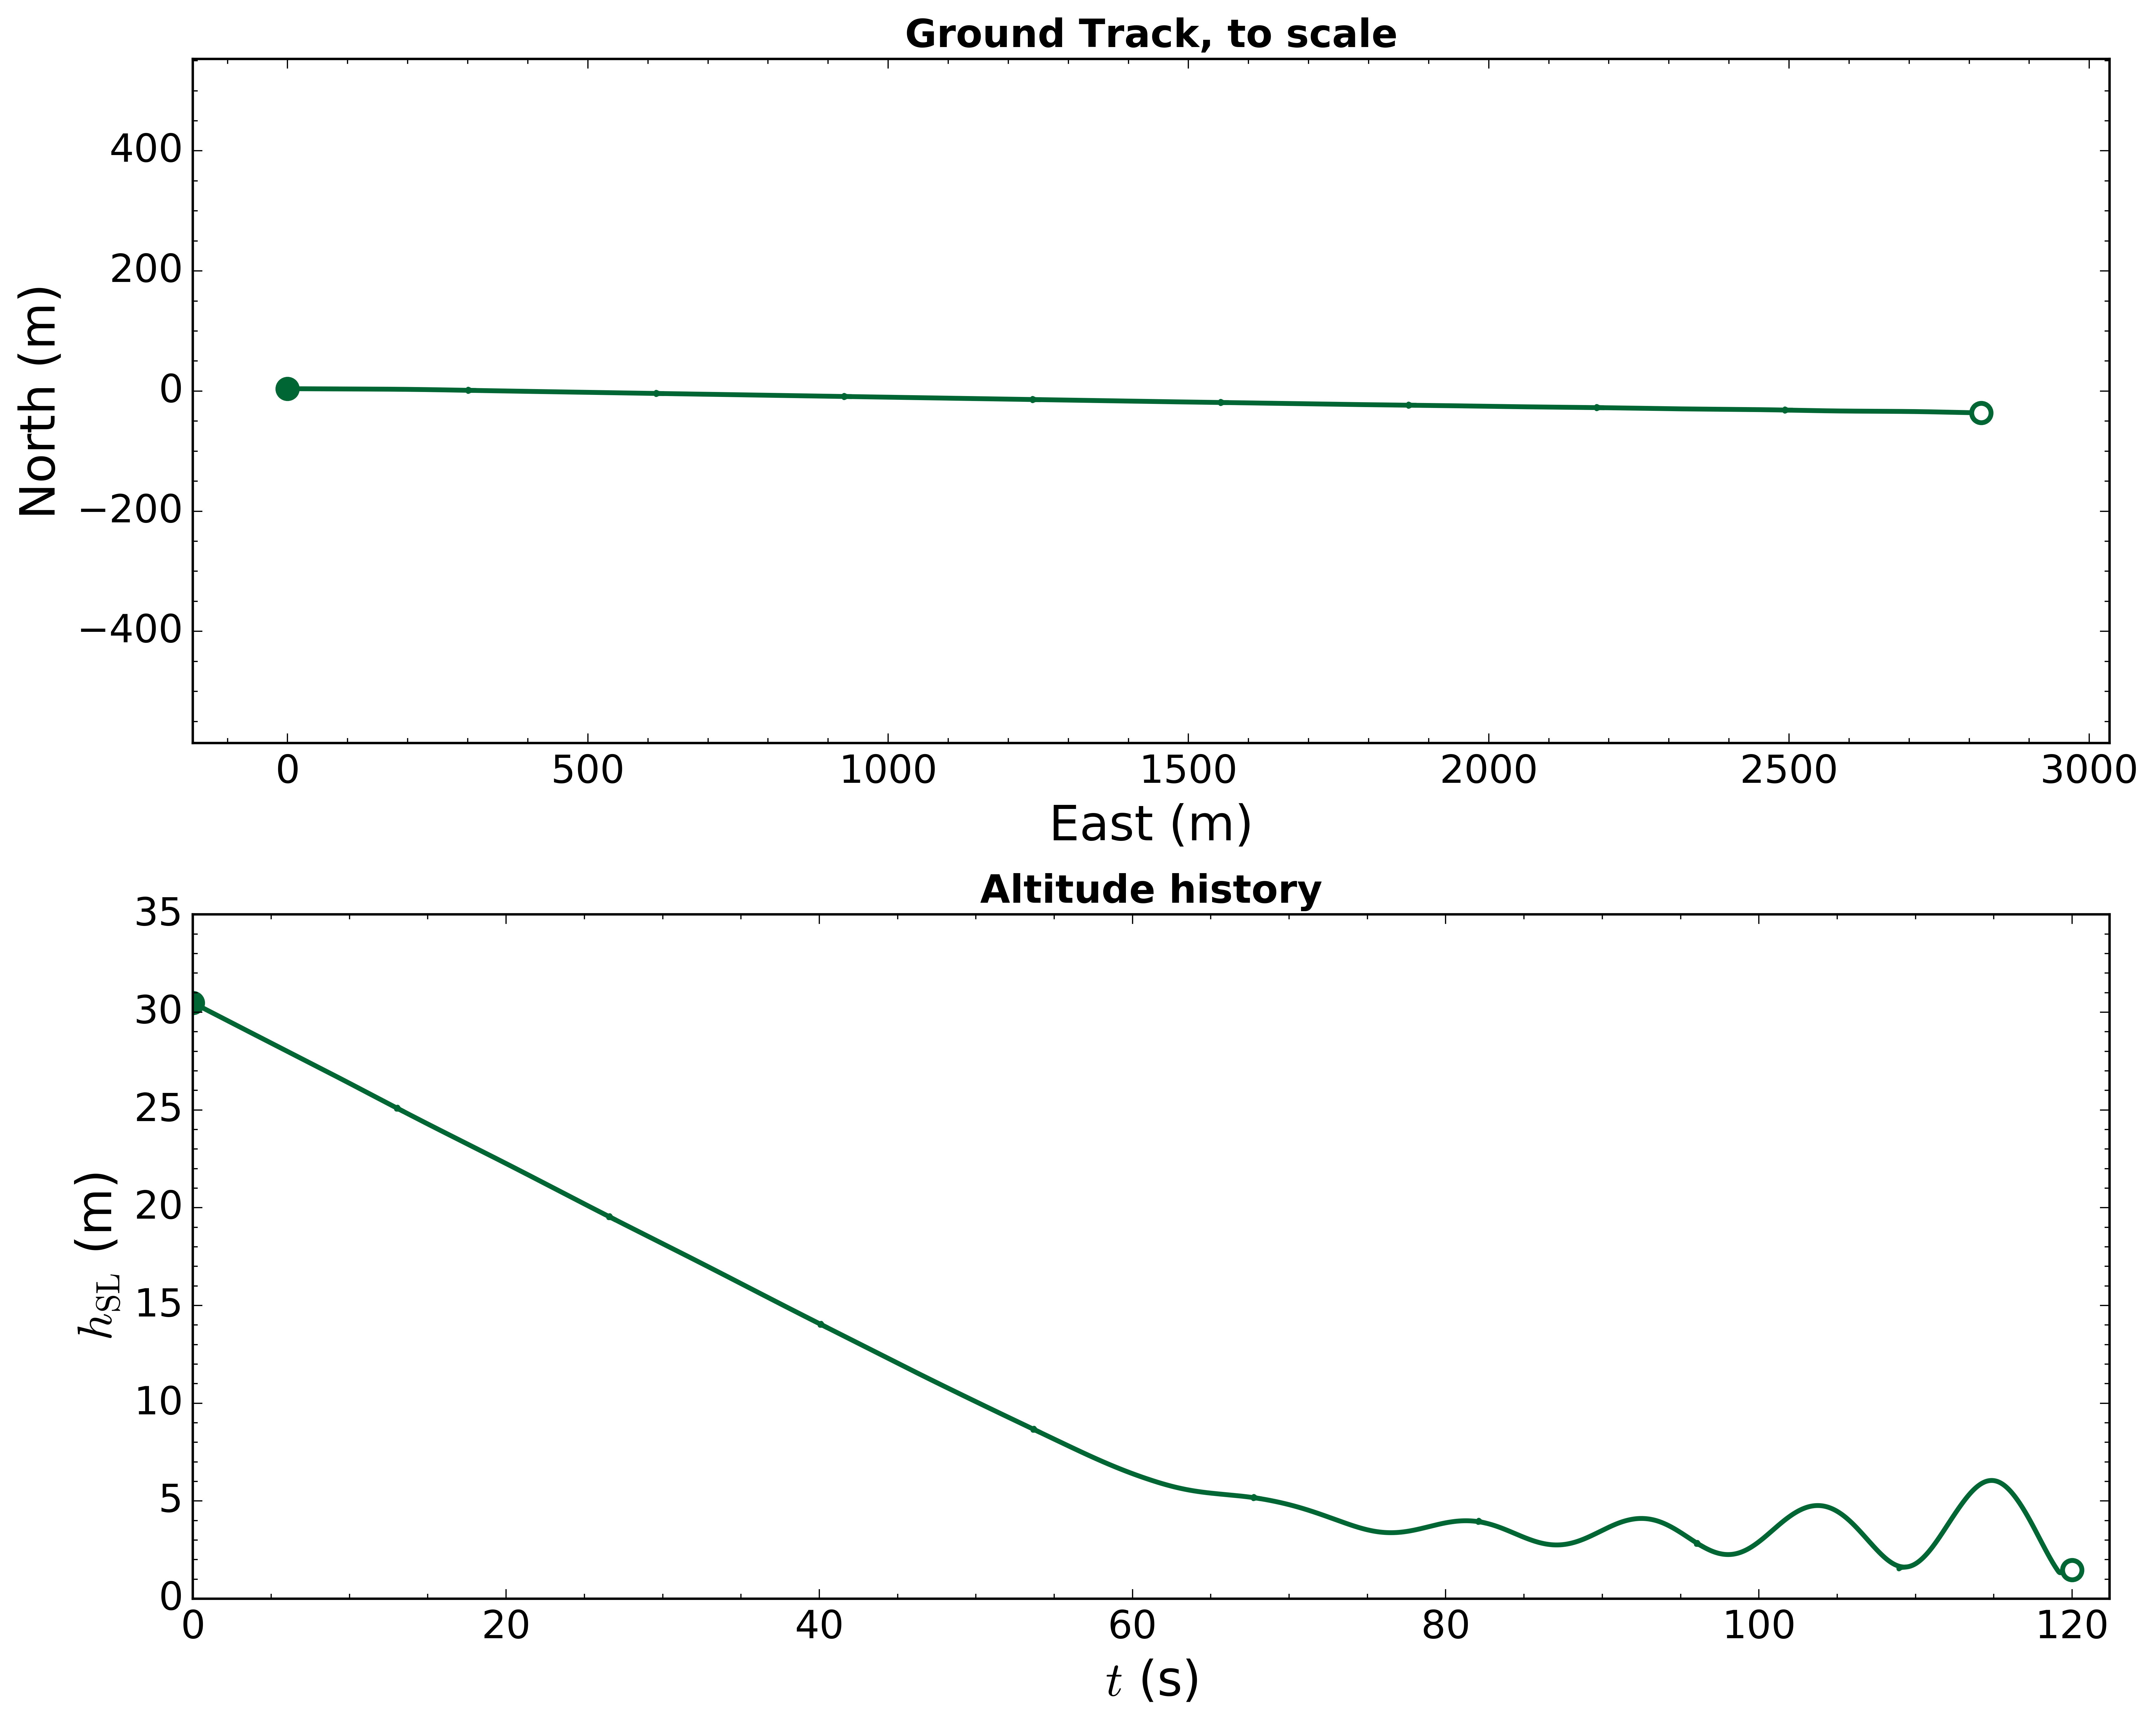

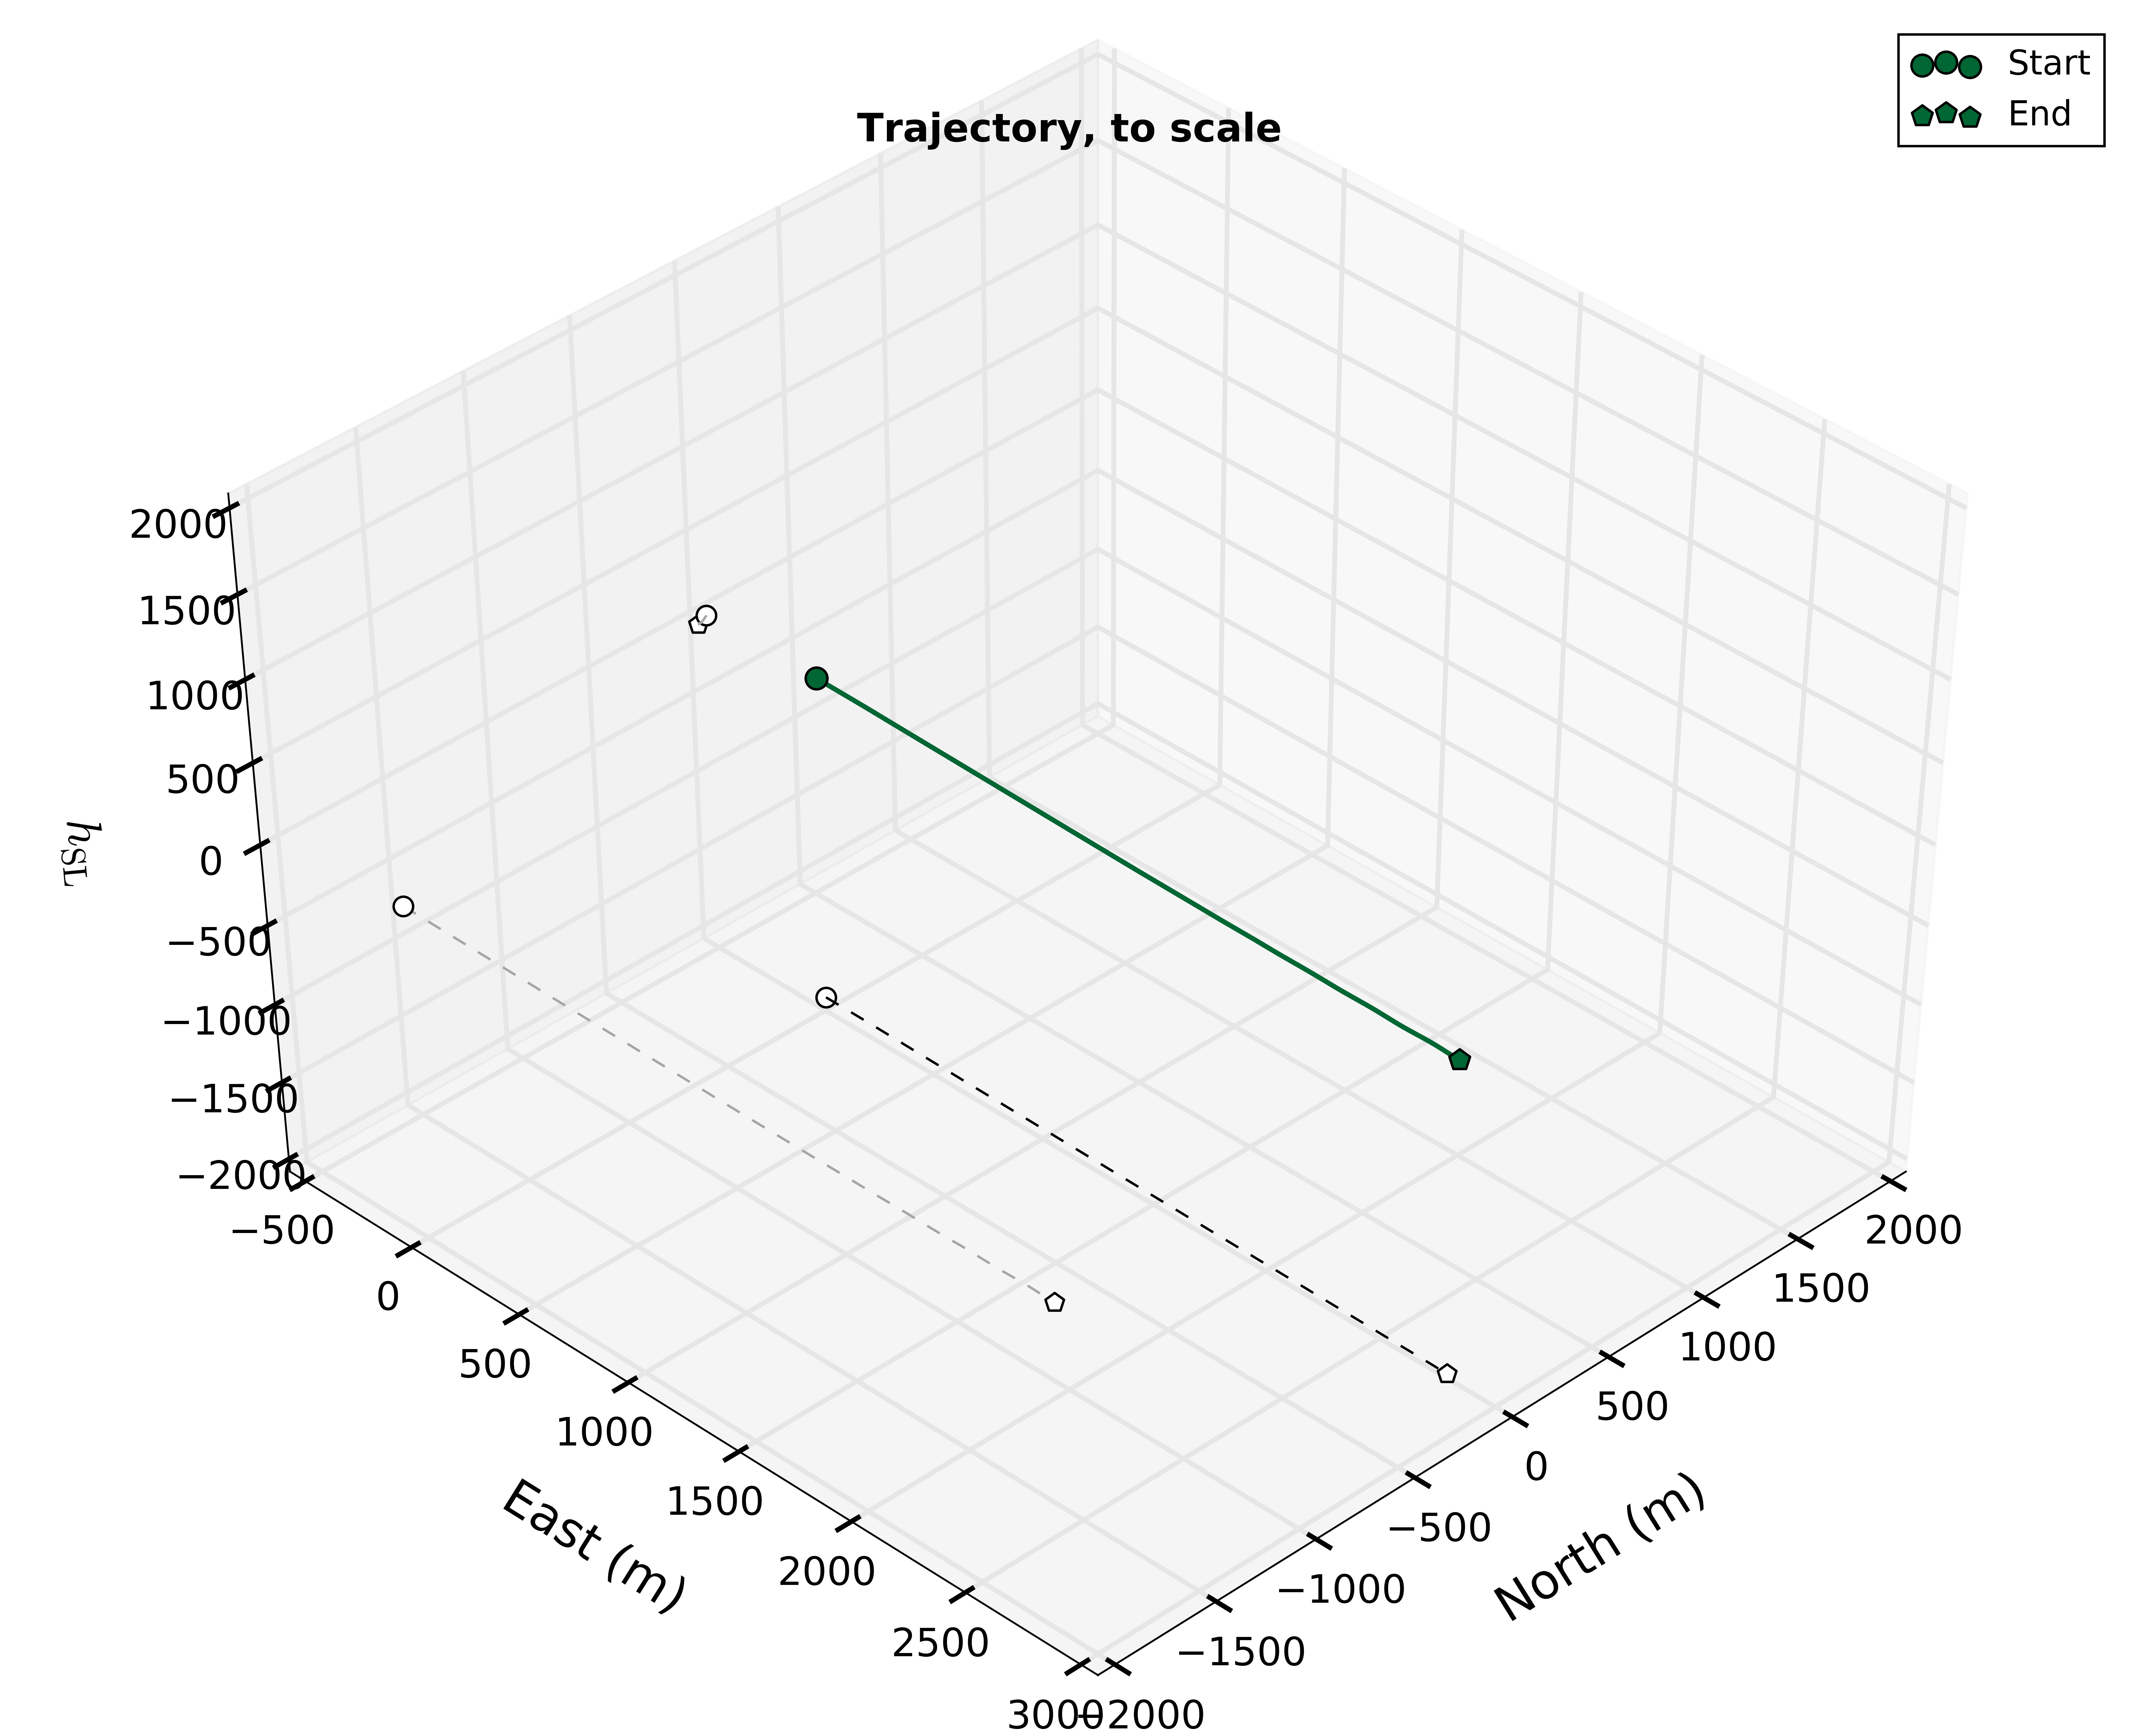

In [7]:
# Plotting in NEA reference frame
import geography as geo
import plotting_utilities as plut

t_pos     = (data_pos[:,0]*unit.s).magnitude
h_sl      = ((data_pos[:,1]*unit.ft).to(unit.m)).magnitude
lat_deg   = (data_pos[:,7]*unit.deg).magnitude
lon_deg   = (data_pos[:,9]*unit.deg).magnitude
lat_rad   = ((lat_deg*unit.deg).to(unit.rad)).magnitude
lon_rad   = ((lon_deg*unit.deg).to(unit.rad)).magnitude

r = geo.geoc_to_NEA(lat_rad,lon_rad,h_sl,flat=1)

plrt.plot_traj2D_NEA(r,t_pos,n_arrows=8,arrow_size=2, dest_folder=dest_folder)
plrt.plot_traj3D_NEA(r,'S','W',view=(45,45),to_scale='XYZ',mrk_size=80,dest_folder=dest_folder)